In [1]:
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [53]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
num_epochs = 20
encoder_ver = f'{n_hidden}h{num_epochs}e'

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')

(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


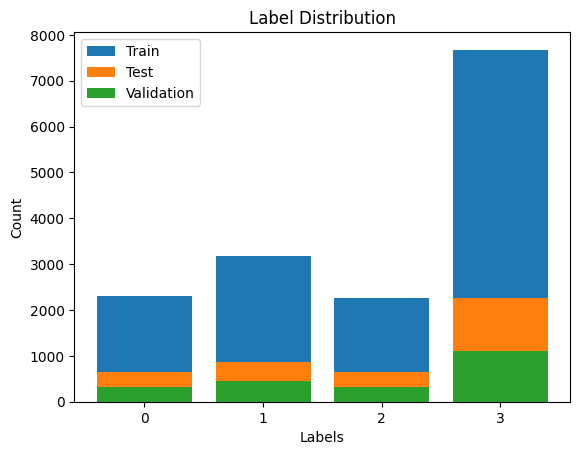

In [65]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [69]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_type, dataset_ver):
        self.X = np.array(np.load(f'Generated_Datasets/{dataset_type}_data_{dataset_ver}.npy'))
        self.y = np.array(np.load(f'Generated_Datasets/{dataset_type}_labels_{dataset_ver}.npy'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(np.asarray(self.y[idx])).float()
        return X, y

In [9]:
# Unidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        # x = x.repeat(60, 1, 1)
        # x = x.reshape(x.shape[1], 60, self.hidden_size)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
autoencoder = Autoencoder(n_input, n_hidden).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)


In [67]:
# Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        # print("Final Encoded: ", encoded_x.shape)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # print("Decoder x: ", x.shape)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        # print("Reshaped Decoder x: ", x.shape)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
# RNN
class DANA(nn.Module):
    def __init__(self, inp_shape, out_shape):
        super(DANA, self).__init__()
        nb_filters = 64
        nb_dense = 512
        nb_dropout = 128

        # self.conv = nn.Conv1d(inp_shape, nb_filters, kernel_size=3, padding=1)
        # self.relu = nn.ReLU()
        # self.lstm = nn.LSTM(nb_filters, nb_dense, batch_first=True, bidirectional=True)
        # self.fc1 = nn.Linear(nb_dense*2, nb_dropout)
        # self.dropout = nn.Dropout(0.5)
        # self.fc2 = nn.Linear(nb_dropout, out_shape)
        self.lstm = nn.LSTM(inp_shape, 360, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(360, nb_dropout)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(nb_dropout, out_shape)

        self.loss = nn.MSELoss()

    def forward(self, x):
        # x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        # x = self.conv(x)
        # x = self.relu(x)
        # print("CONV:", x.shape)
        # x = x.permute(0, 2, 1)
        # print(x.shape)
        x, (hidden, _) = self.lstm(x) # lstm = (batch, seq length, input_size)
        print(hidden.shape)
        x = hidden[0, :, :] + hidden[1, :, :]
        print(x.shape)
        # x = x[:, -1]
        # print("LSTM:",x.shape)
        x = self.fc1(x)
        # print("Linear1:",x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        # print("Linear2:",x.shape)

        return x

autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)

DANA(
  (lstm): LSTM(9, 360, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=360, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (loss): MSELoss()
)


In [70]:
### Train AutoEncoder ###
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Define Model ###
autoencoder = Autoencoder(n_input, n_hidden).to(device)
# autoencoder = LSTM(n_input, n_hidden, 3, 0.5, True)
# autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)


optimizer = optim.Adam(autoencoder.parameters(),
                        lr=1e-3,
                        betas=(0.9, 0.999),
                        eps=1e-8)
optimizer.zero_grad()

best_loss = np.inf
train_losses = []

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch+1}...')
    for batch in tqdm(train_dataloader):
        X_batch, y_batch = batch
        X = X_batch.to(device)
        # X = X.permute(0, 2, 1)
        # print("Input:", X.shape)
        y = y_batch.to(device).reshape(-1, 1)

        pred = autoencoder(X)
        # print("Pred:", pred.shape)
        loss_value = autoencoder.loss(pred, X)

        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_losses.append(loss_value.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_value.item():.4f}')
    
    if loss_value.item() < best_loss:
        best_loss = loss_value.item()

        # Save Encoder
        torch.save(autoencoder.encoder, f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt')
        # Save Full Autoencoder
        torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_Autoencoder.pt')
        # Save Multi-Layer Perceptron
        # torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_DANA.pt')


Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


C:\Users\BLOOM\AppData\Local\Temp\ipykernel_26392\145480286.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dataloader):


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [1/20], Training Loss: 0.0122
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [2/20], Training Loss: 0.0062
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [3/20], Training Loss: 0.0062
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [4/20], Training Loss: 0.0050
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [5/20], Training Loss: 0.0056
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [6/20], Training Loss: 0.0063
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [7/20], Training Loss: 0.0048
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [8/20], Training Loss: 0.0042
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [9/20], Training Loss: 0.0036
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [10/20], Training Loss: 0.0038
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [11/20], Training Loss: 0.0040
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [12/20], Training Loss: 0.0031
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [13/20], Training Loss: 0.0028
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [14/20], Training Loss: 0.0032
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [15/20], Training Loss: 0.0027
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [16/20], Training Loss: 0.0031
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [17/20], Training Loss: 0.0025
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [18/20], Training Loss: 0.0018
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [19/20], Training Loss: 0.0019
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch [20/20], Training Loss: 0.0022


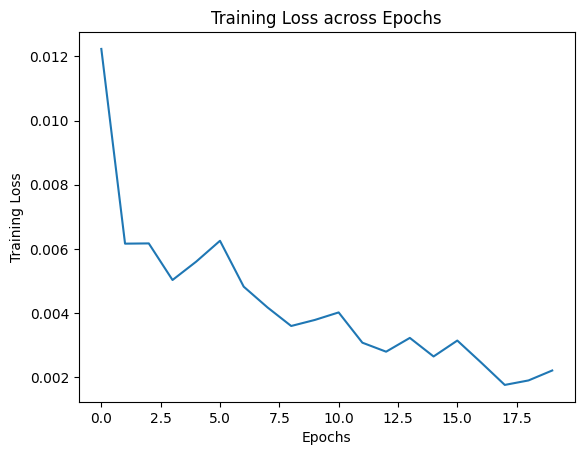

In [71]:
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss across Epochs')
plt.show()

In [72]:
### Train SVM ###
def train_svm(train_data, train_labels):
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=0)
    svm_classifier = svm.SVC(kernel='rbf', probability=True)
    svm_classifier.fit(x_train, y_train)

    test_pred = svm_classifier.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, test_pred)}')

    return svm_classifier

train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print('Loading Encoder Model...')
encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt').to(device)
# encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_DANA.pt').to(device)
encoder.eval()

encoded_data = []
labels = []

print('Encoding Data...')
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        X_batch, y_batch = batch
        X = X_batch.to(device)
        y = y_batch.to(device).reshape(-1, 1)

        encoded_batch = encoder(X)
        # print(encoded_batch.shape)

        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])

        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        encoded_data.append(encoded_batch)
        labels.append(y)

    encoded_data = torch.cat(encoded_data, 0).cpu()
    labels = torch.cat(labels, 0).cpu()       

print(f'{encoded_data.shape=}')
print(f'{labels.shape=}')

print("Training SVM Classifier...")
svm_classifier = train_svm(encoded_data, labels.ravel())

# Save SVM Classifier
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_svm_classifier.pkl', "wb") as file:
    pickle.dump(svm_classifier, file)

Loading Encoder Model...
Encoding Data...


C:\Users\BLOOM\AppData\Local\Temp\ipykernel_26392\3858648355.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dataloader):


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9412719013627514


In [73]:
### Test SVM + Encoder ###

# Model Params
encoder_ver = f'{n_hidden}h{num_epochs}e'
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load the saved models
autoencoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_Autoencoder.pt')
autoencoder.eval()
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_svm_classifier.pkl', 'rb') as file:
    svm_classifier = pickle.load(file)

test_encoded_data = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        X_batch, y_batch = batch
        X = X_batch.to(device)
        y = y_batch.to(device).reshape(-1, 1)

        test_encoded_batch = autoencoder.encoder(X)
        # print(encoded_batch.shape)
        
        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])
        
        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        test_encoded_data.append(test_encoded_batch)
        test_labels.append(y)

    test_encoded_data = torch.cat(test_encoded_data, 0).cpu()
    test_labels = torch.cat(test_labels, 0).cpu()   

print(f'{test_encoded_data.shape=}')
print(f'{test_labels.shape=}')

test_predictions = svm_classifier.predict(test_encoded_data)
print(f'{test_predictions.shape=}')

C:\Users\BLOOM\AppData\Local\Temp\ipykernel_26392\488158750.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(test_dataloader):


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)


Accuracy: 94.28%


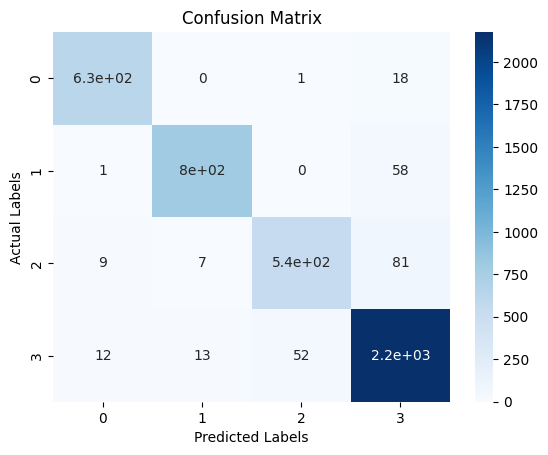

In [74]:
# Calculate accuracy score
accuracy = accuracy_score(test_labels, test_predictions)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels and title to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()